In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def f(x):
    return 4*x**2 - 3*x + 2

print (f(2))

12


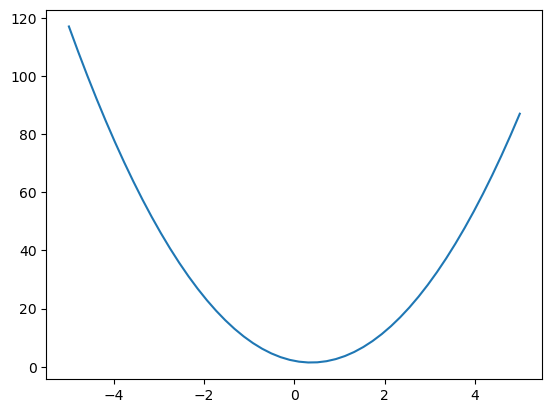

In [3]:
xs = np.linspace(-5, 5)
ys = f(xs)

plt.plot(xs, ys)

In [99]:
class Value:

    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = backward
        
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Should be int or float"
        out = Value ((self.data ** other), (self, ), '**')
        def backward():
            self.grad = other * self.data ** (other - 1) * out.grad
        out._backward = backward
        return out

    def __truediv__(self, other):
        return self * (other ** -1)

    def __sub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * (-1)
    
    def exp (self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")
        
        def backward():
            self.grad += out.data * out.grad
        out._backward = backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")
        def backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = backward
        return out
    
    def backward(self):
        self.grad = 1
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()

In [6]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={'rankdir': "LR"}) #LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            # connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot    


In [7]:
# add a neuron

In [63]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value (-3.0, label='w1')
w2 = Value (1.0, label='w2')

#bias of the neuron
b1 = Value(6.8813735870195432, label='b1')

#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b1; n.label = 'n'
o = n.tanh()
o.label = "o"

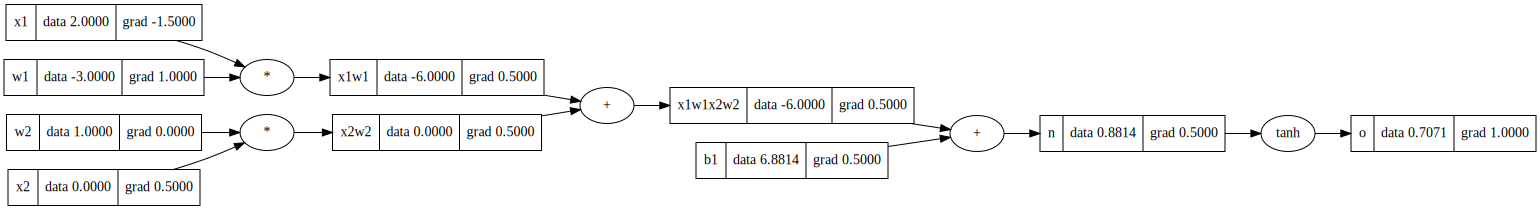

In [64]:
o.backward()
draw_dot(o)

In [65]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value (-3.0, label='w1')
w2 = Value (1.0, label='w2')

#bias of the neuron
b1 = Value(6.8813735870195432, label='b1')

#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b1; n.label = 'n'
e  = (2*n).exp(); e.label = "e"
o = (e - 1) / (e + 1)
o.label = "o"


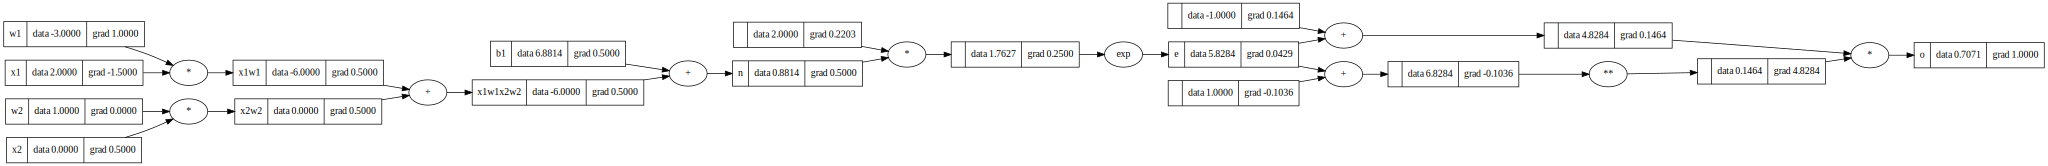

In [66]:
o.backward()
draw_dot(o)

In [119]:
class Neuron:
    def __init__(self, nin):
        # nin --> Number of inputs for one single neuron
        self.w = [Value(np.random.uniform (-1, 1)) for n in range(nin)]
        self.b = Value (np.random.uniform(-1, 1)) 

    def __call__(self, x):
        return (sum((xi * wi for xi, wi in zip (x, self.w)), self.b)).tanh()

    def params(self):
        return [self.b] + self.w
        
class Layer:
    def __init__(self, nin, nout):
        # nin --> Length of list of Value object which will be the list
        # nout --> Number of neurons in this layer
        self.n = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [ni(x) for ni in self.n]
        return out[0] if len(out) == 1 else out

    def params(self):
        return [p for neuron in self.n for p in neuron.params()]

class MLP:
    def __init__(self, nl, ns):
        # nl --> number of layers
        # ns --> the out neurons in each layer correspondingly
        sz = [nl] + ns
        self.mlp = [Layer(sz[i], sz[i + 1]) for i in range(len(ns))]

    def __call__(self, x):
        for layer in self.mlp:
            x = layer(x)
        return x

    def params(self):
        return [p for layer in self.mlp for p in layer.params()] 

neuron = Neuron(3)
print (len(neuron.params()))
x = [Value (4), Value(6)]
l = Layer(2, 3)
print (len(l.params()))
mlp = MLP(2, [2, 3, 1])
print (len(mlp.params()))


4
9
19


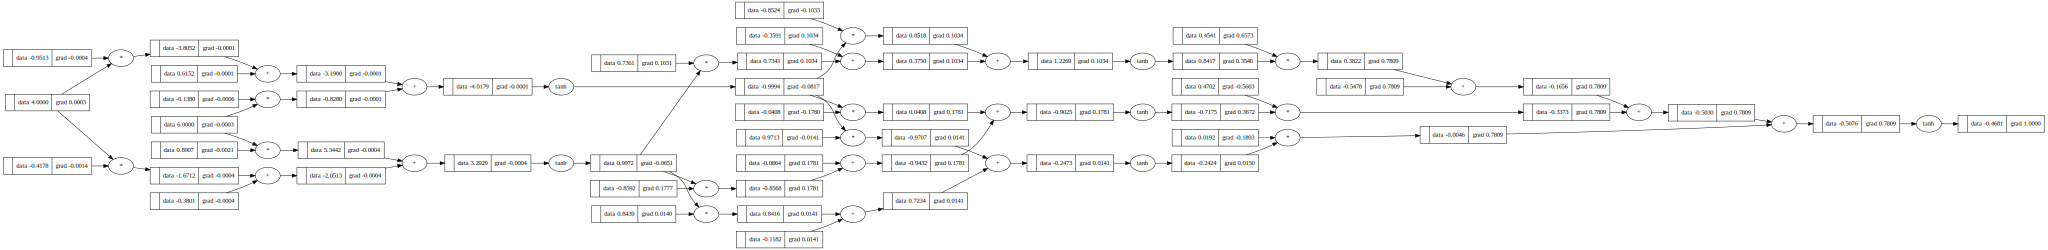

In [103]:
final = mlp(x)
final.backward()

draw_do

In [246]:
mlp = MLP(3, [4, 4, 1])
xs = [
    [2.0, 3.0, 1.0],
    [4.0, -1.0, 3.0],
    [1.5, 2.0, 1.0],
    [0.0, 1.4, 3.6]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [315]:
ypred = [mlp(xi) for xi in xs]

In [316]:
loss = sum((yout - ygt) **2 for yout, ygt in zip(ypred, ys))
loss

Value(data=2.427478200223324)

In [317]:
loss.backward()


In [318]:
for p in mlp.params():
    p.data += -0.03 * p.grad

In [319]:
ypred

[Value(data=0.46011123552269234),
 Value(data=-0.9846112357208987),
 Value(data=0.46142447429342953),
 Value(data=0.9998813213337948)]